# Replicación Artículo: Comparative Analysis os Machine Learning Algorithms for Solar Irradiance Forecasting in Smart Grids

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
datos = pd.read_excel("02.Generación Pearson.xlsx")
datos.head(4)

,Fecha,Generación,Índice UV,Temperatura,Hora,DPT,Cobertura Nubes,Condición Cielo,Humedad Relativa
0,2022-09-01 00:00:00,0.0,0.0,19,24,15,98,4,77
1,2022-09-01 01:00:00,0.0,0.0,19,1,16,82,4,82
2,2022-09-01 02:00:00,0.0,0.0,18,2,16,73,3,85
3,2022-09-01 03:00:00,0.0,0.0,18,3,16,63,3,87


In [5]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18290 entries, 0 to 18289
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Fecha             18290 non-null  datetime64[ns]
 1   Generación        18290 non-null  float64       
 2   Índice UV         18290 non-null  float64       
 3   Temperatura       18290 non-null  int64         
 4   Hora              18290 non-null  int64         
 5   DPT               18290 non-null  int64         
 6   Cobertura Nubes   18290 non-null  int64         
 7   Condición Cielo   18290 non-null  int64         
 8   Humedad Relativa  18290 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6)
memory usage: 1.3 MB


In [6]:
datos_sinfecha = datos.drop(["Fecha"], axis=1)

In [7]:
datos_sinfecha.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18290 entries, 0 to 18289
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Generación        18290 non-null  float64
 1   Índice UV         18290 non-null  float64
 2   Temperatura       18290 non-null  int64  
 3   Hora              18290 non-null  int64  
 4   DPT               18290 non-null  int64  
 5   Cobertura Nubes   18290 non-null  int64  
 6   Condición Cielo   18290 non-null  int64  
 7   Humedad Relativa  18290 non-null  int64  
dtypes: float64(2), int64(6)
memory usage: 1.1 MB


In [8]:
datos_sinfecha.describe().T

,count,mean,std,min,25%,50%,75%,max
Generación,18290.0,9392.470410,11398.664257,0.0,0.0,532.0,21829.75,30000.0
Índice UV,18290.0,1.976309,3.181351,0.0,0.0,0.0,3.00,14.0
Temperatura,18290.0,19.456698,6.636539,0.0,15.0,19.0,24.00,39.0
Hora,18290.0,12.501312,6.923137,1.0,7.0,13.0,19.00,25.0
DPT,18290.0,9.838163,4.803726,0.0,6.0,10.0,14.00,20.0
Cobertura Nubes,18290.0,50.308201,37.865105,0.0,12.0,48.0,92.00,100.0
Condición Cielo,18290.0,2.675888,1.493505,1.0,1.0,3.0,4.00,5.0
Humedad Relativa,18290.0,58.879224,26.112205,3.0,37.0,62.0,83.00,100.0


In [9]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error as mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error as mean_absolute_error
from sklearn.metrics import mean_squared_error as mean_squared_error
from sklearn.metrics import r2_score as r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
def train_time_series_with_folds(df, model, horizon=24*10):
    X = df.drop('Generación', axis=1)
    #X = df[['Anio', 'NumDiaAnio', 'Temperatura', 'CodCondCielo', 'CodDirViento', 'IndiceUV', 'NumDia', 
   # 'NumHora', 'ProbabilidadLluvia', 'DPT', 'CoberturaNubes']]
    y = df['Generación']
    
    #take last week of the dataset for validation
    X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:]
    y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]
    
    #create, train and do inference of the model
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    predictions = np.clip(predictions, 0, 30000)
    
    #calculate MAE
    mae = np.round(mean_absolute_error(y_test, predictions), 3)
    mape = np.round(mean_absolute_percentage_error(y_test, predictions), 3)    
    r2 = np.round(r2_score(y_test, predictions), 3)    
    rmse = np.round(np.sqrt(mean_squared_error(y_test, predictions)), 3)    
    
    #plot reality vs prediction for the last week of the dataset
    fig = plt.figure(figsize=(16,8))
    plt.title(f'Real vs Prediction - MAE {mae} - MAPE {mape} - R2 {r2} - RMSE {rmse}', fontsize=20)
    plt.plot(y_test, color='red')
    plt.plot(pd.Series(predictions, index=y_test.index), color='green')
    plt.xlabel('Hour', fontsize=16)
    plt.ylabel('Generacion', fontsize=16)
    plt.legend(labels=['Real', 'Prediction'], fontsize=16)
    plt.grid()
    plt.show()
    
    #create a dataframe with the variable importances of the model
    # Crear DataFrame con la importancia de variables
    df_importances = pd.DataFrame({
        'feature': X_train.columns,  # Obtiene los nombres de las características
        'importance': model.feature_importances_
    }).sort_values(by='importance', ascending=False)
    
    #plot variable importances of the model
    plt.title('Variable Importances', fontsize=16)
    sns.barplot(x=df_importances.importance, y=df_importances.feature, orient='h')
    plt.show()

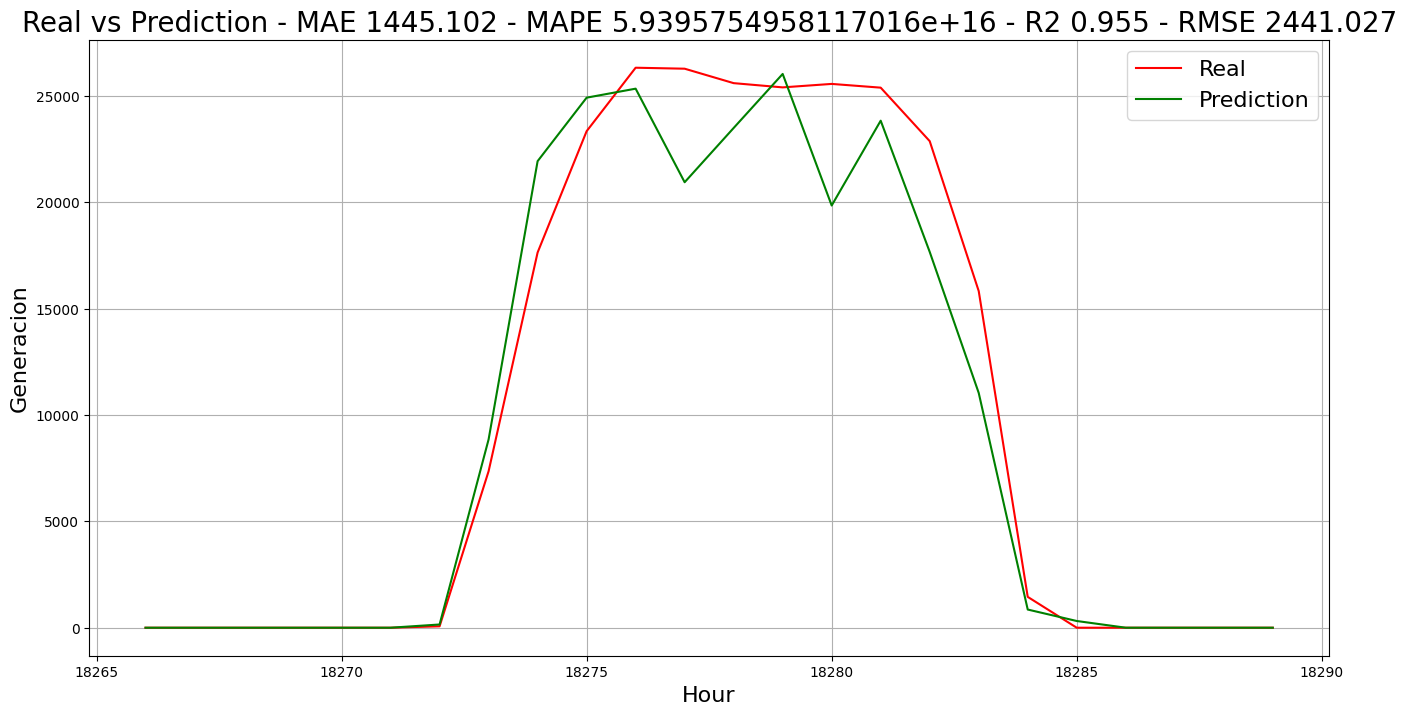

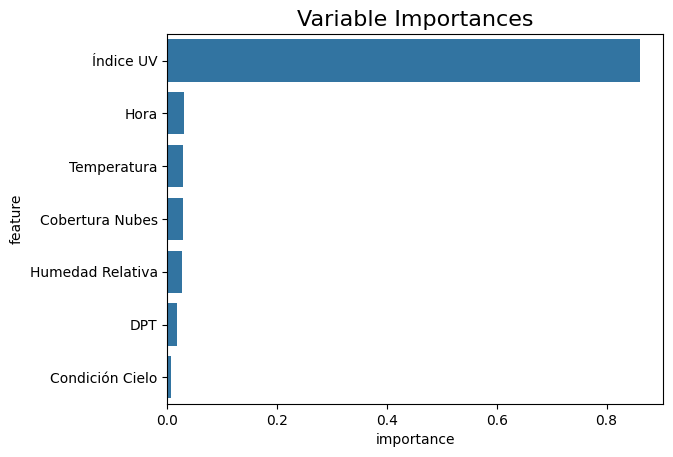

In [13]:
train_time_series_with_folds(datos_sinfecha, RandomForestRegressor(), 24)

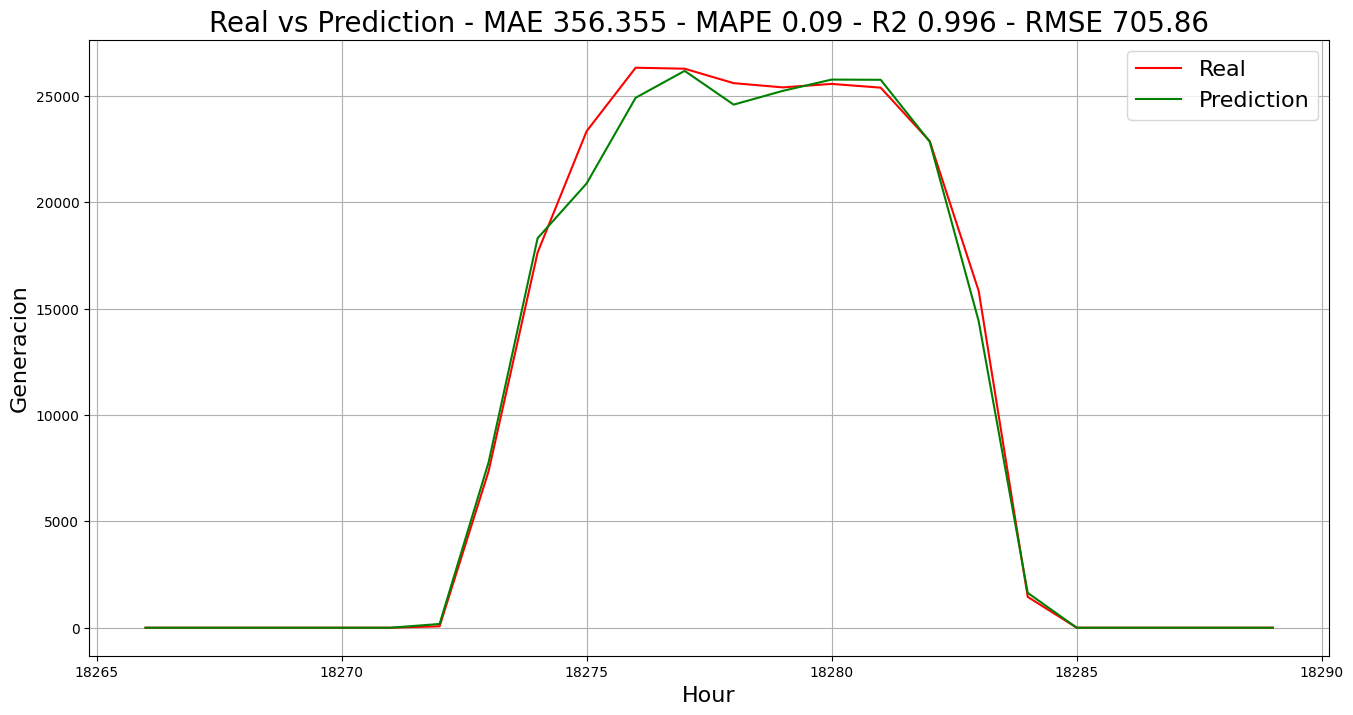

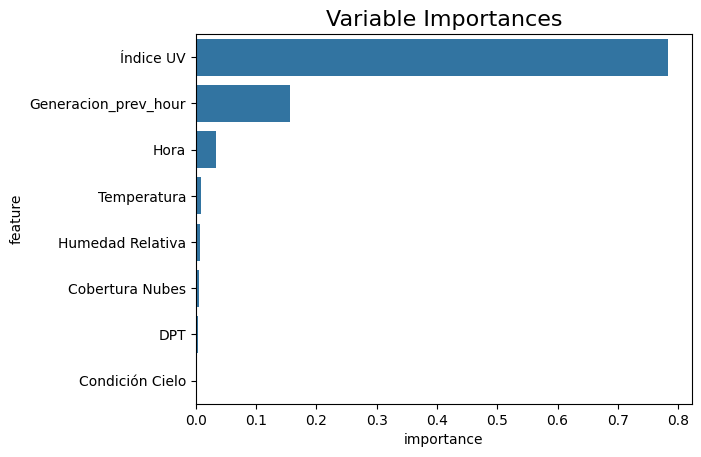

In [14]:
datos_2 = datos_sinfecha.copy()
datos_2["Generacion_prev_hour"] = datos_2["Generación"].shift(1)
datos_dropna = datos_2.dropna(how="any", axis= 0)
train_time_series_with_folds(datos_dropna, RandomForestRegressor(), 24)

In [31]:
from timeit import default_timer as timer
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [32]:
X = datos_dropna.drop('Generación', axis=1)
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X = X_scaled_df.copy()
y = datos_dropna['Generación']

In [33]:
X.sample(4)

,Índice UV,Temperatura,Hora,DPT,Cobertura Nubes,Condición Cielo,Humedad Relativa,Generacion_prev_hour
11462,0.321748,-0.370181,0.216582,-0.382607,0.388089,0.886647,-0.186821,0.921969
18139,-0.621258,0.684585,0.938853,0.658285,-0.483463,-0.452513,-0.340008,0.531653
8597,-0.621258,-0.370181,-1.083504,1.074641,-0.536285,0.217067,1.076973,-0.824058
11465,-0.306922,0.232543,0.649945,-0.590785,-0.668338,-0.452513,-0.646382,0.846871


In [34]:
#Porcentaje de entrenamiento
porcentaje = 0.8

#Horizonte de predicción
horizon = 1

In [35]:
#División de datos
lentrain100 = int(len(y) * porcentaje)
lentrain100

14631

In [36]:
#Dividimos 80/20
X_train, X_test = X.iloc[:lentrain100, :], X.iloc[lentrain100:, :]
y_train, y_test = y.iloc[:lentrain100], y.iloc[lentrain100:]

In [37]:
resultados = pd.DataFrame(columns=['Hora', 'Real', 'Predicho'])

In [38]:
#Modelo LightGBM
model = RandomForestRegressor(
    criterion="squared_error",
    random_state=0,
    n_estimators=400,
    min_impurity_decrease=0,
    max_depth=None,
    bootstrap=True
)

In [39]:
#Entrenamos en el 80% de los datos
start = timer()
model.fit(X_train, y_train)
end = timer()
print(f"Tiempo de entrenamiento: {end - start:.4f} segundos.")

Tiempo de entrenamiento: 25.6211 segundos.


In [40]:
#Evaluar en cada segmento de 1 día dentro del 20% de los datos
num_pruebas = len(X_test) // horizon
num_pruebas

3658

In [41]:
X_test

,Índice UV,Temperatura,Hora,DPT,Cobertura Nubes,Condición Cielo,Humedad Relativa,Generacion_prev_hour
14631,1.893424,2.342076,0.361037,-1.215320,-1.328605,-1.122093,-1.948472,1.630486
14632,0.950418,2.492757,0.505491,-1.423499,-1.328605,-1.122093,-1.948472,1.614343
14633,0.321748,2.643438,0.649945,-1.423499,-1.222962,-1.122093,-1.948472,1.307460
14634,0.007413,2.492757,0.794399,-1.631677,-1.090909,-1.122093,-1.910175,1.201305
14635,-0.306922,2.342076,0.938853,-1.839855,-0.985266,-1.122093,-1.871879,0.689042
...,...,...,...,...,...,...,...,...
18284,-0.621258,0.383224,1.083307,-0.174429,-1.275784,-1.122093,-0.531492,-0.696848
18285,-0.621258,0.081862,1.227761,0.033750,-1.302195,-1.122093,-0.186821,-0.824058
18286,-0.621258,-0.219500,1.372215,0.241928,-1.328605,-1.122093,0.119554,-0.824058
18287,-0.621258,-0.370181,1.516669,0.241928,-1.328605,-1.122093,0.387631,-0.824058


In [42]:
# Inicializar listas para métricas
resultados = pd.DataFrame(columns=['Hora', 'Real', 'Predicho'])
#Ciclo diario de predicción
for i in range(num_pruebas):
    inicio = i * horizon
    fin = inicio + horizon

    X_test_seg = X_test.iloc[inicio:fin, :]
    y_test_seg = y_test.iloc[inicio:fin]

    if len(X_test_seg) < horizon:
        break

    y_pred = model.predict(X_test_seg)
    y_pred = np.clip(y_pred, 0, 30000)  # 🔹 Limitamos entre 0 y 30,000

    df_temp = pd.DataFrame({
        'Hora': X_test_seg.index,
        'Real': y_test_seg,
        'Predicho': y_pred
    })

    resultados = pd.concat([resultados, df_temp], ignore_index=True)

In [43]:
print(f"MAE: {mean_absolute_error(resultados['Real'], resultados['Predicho']):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(resultados['Real'], resultados['Predicho'])):.4f}")
print(f"R²: {r2_score(resultados['Real'], resultados['Predicho']):.4f}")

MAE: 1006.6116
RMSE: 2293.8321
R²: 0.9621


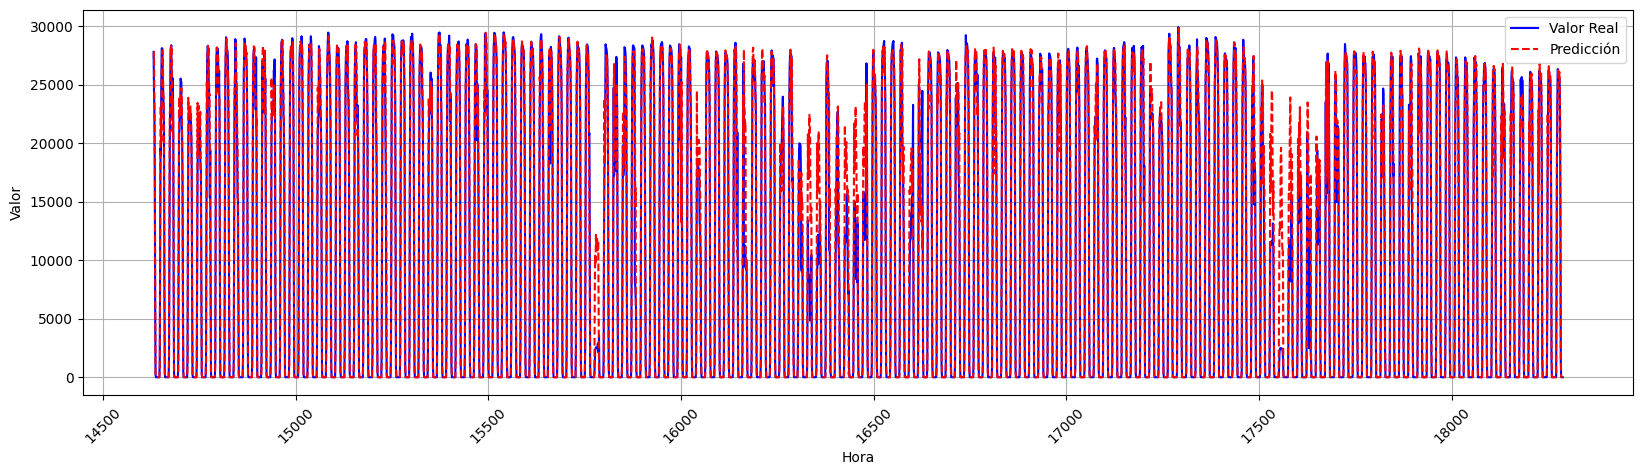

In [48]:
plt.figure(figsize=(20, 5))
plt.plot(resultados['Hora'], resultados['Real'], label='Valor Real', color='blue')
plt.plot(resultados['Hora'], resultados['Predicho'], label='Predicción', color='red', linestyle='dashed')
plt.xlabel("Hora")
plt.ylabel("Valor")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

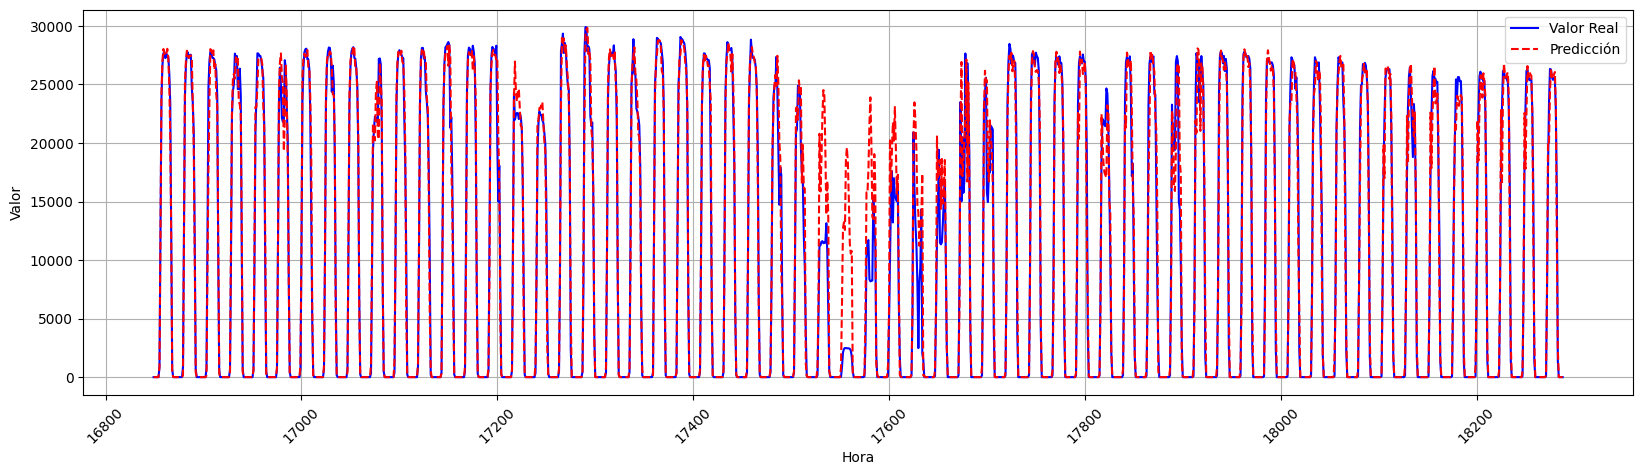

In [49]:
resultados_filtro = resultados.iloc[-(24*60):,:]
plt.figure(figsize=(20, 5))
plt.plot(resultados_filtro['Hora'], resultados_filtro['Real'], label='Valor Real', color='blue')
plt.plot(resultados_filtro['Hora'], resultados_filtro['Predicho'], label='Predicción', color='red', linestyle='dashed')
plt.xlabel("Hora")
plt.ylabel("Valor")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

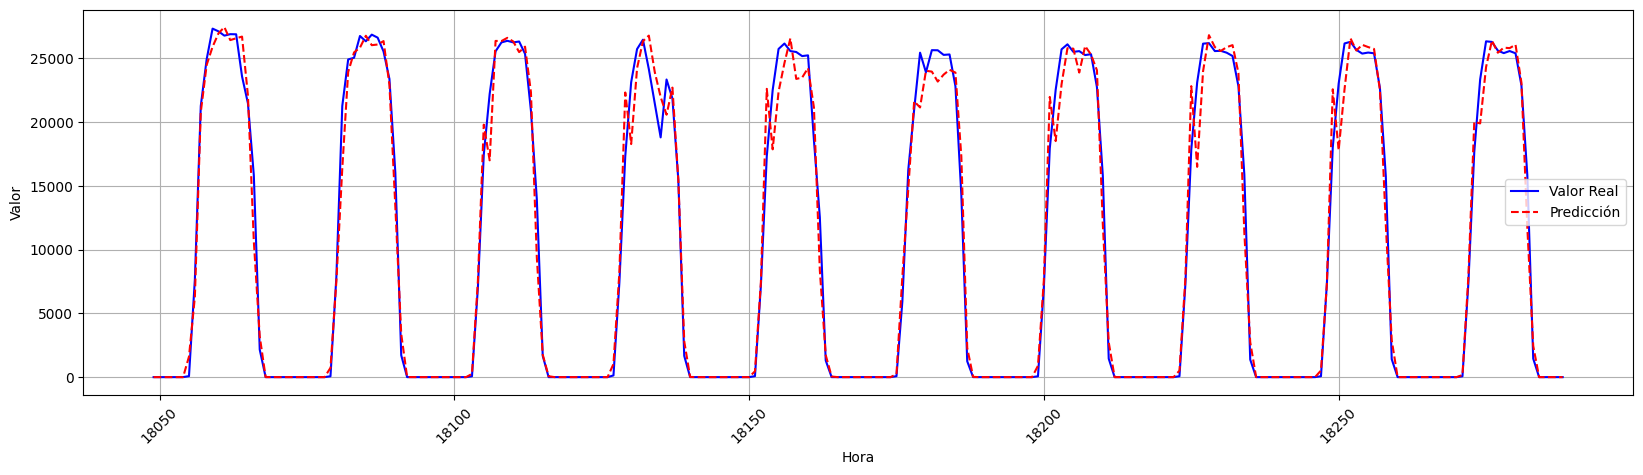

In [50]:
resultados_filtro = resultados.iloc[-(24*10):,:]
plt.figure(figsize=(20, 5))
plt.plot(resultados_filtro['Hora'], resultados_filtro['Real'], label='Valor Real', color='blue')
plt.plot(resultados_filtro['Hora'], resultados_filtro['Predicho'], label='Predicción', color='red', linestyle='dashed')
plt.xlabel("Hora")
plt.ylabel("Valor")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()